In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Class and Model

In [ ]:
# lenet base model for Pareto MTL
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.modules.loss import CrossEntropyLoss


class RegressionTrain(torch.nn.Module):

    def __init__(self, model,init_weight):
        super(RegressionTrain, self).__init__()

        self.model = model
        self.weights = torch.nn.Parameter(torch.from_numpy(init_weight).float())
        self.ce_loss = CrossEntropyLoss()

    def forward(self, x, ts):
        n_tasks = 2
        ys = self.model(x)

        task_loss = []
        for i in range(n_tasks):
            task_loss.append( self.ce_loss(ys[:,i], ts[:,i]) )
        task_loss = torch.stack(task_loss)

        return task_loss


class RegressionModel(torch.nn.Module):
    def __init__(self, n_tasks):
        super(RegressionModel, self).__init__()
        self.n_tasks = n_tasks
        self.conv1 = nn.Conv2d(1, 10, 9, 1)
        self.conv2 = nn.Conv2d(10, 20, 5, 1)
        self.fc1 = nn.Linear(5*5*20, 50)

        for i in range(self.n_tasks):
            setattr(self, 'task_{}'.format(i), nn.Linear(50, 10))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*5*20)
        x = F.relu(self.fc1(x))


        outs = []
        for i in range(self.n_tasks):
            layer = getattr(self, 'task_{}'.format(i))
            outs.append(layer(x))

        return torch.stack(outs, dim=1)

In [ ]:
# This code is from
# Multi-Task Learning as Multi-Objective Optimization
# Ozan Sener, Vladlen Koltun
# Neural Information Processing Systems (NeurIPS) 2018
# https://github.com/intel-isl/MultiObjectiveOptimization

import numpy as np
import torch


class MinNormSolver:
    MAX_ITER = 250
    STOP_CRIT = 1e-5

    def _min_norm_element_from2(v1v1, v1v2, v2v2):
        """
        Analytical solution for min_{c} |cx_1 + (1-c)x_2|_2^2
        d is the distance (objective) optimzed
        v1v1 = <x1,x1>
        v1v2 = <x1,x2>
        v2v2 = <x2,x2>
        """
        if v1v2 >= v1v1:
            # Case: Fig 1, third column
            gamma = 0.999
            cost = v1v1
            return gamma, cost
        if v1v2 >= v2v2:
            # Case: Fig 1, first column
            gamma = 0.001
            cost = v2v2
            return gamma, cost
        # Case: Fig 1, second column
        gamma = -1.0 * ( (v1v2 - v2v2) / (v1v1+v2v2 - 2*v1v2) )
        cost = v2v2 + gamma*(v1v2 - v2v2)
        return gamma, cost

    def _min_norm_2d(vecs, dps):
        """
        Find the minimum norm solution as combination of two points
        This is correct only in 2D
        ie. min_c |\sum c_i x_i|_2^2 st. \sum c_i = 1 , 1 >= c_1 >= 0 for all i, c_i + c_j = 1.0 for some i, j
        """
        dmin = 1e8
        for i in range(len(vecs)):
            for j in range(i+1,len(vecs)):
                if (i,j) not in dps:
                    dps[(i, j)] = 0.0
                    for k in range(len(vecs[i])):
                        dps[(i,j)] += torch.dot(vecs[i][k], vecs[j][k]).item()#torch.dot(vecs[i][k], vecs[j][k]).data[0]
                    dps[(j, i)] = dps[(i, j)]
                if (i,i) not in dps:
                    dps[(i, i)] = 0.0
                    for k in range(len(vecs[i])):
                        dps[(i,i)] += torch.dot(vecs[i][k], vecs[i][k]).item()#torch.dot(vecs[i][k], vecs[i][k]).data[0]
                if (j,j) not in dps:
                    dps[(j, j)] = 0.0
                    for k in range(len(vecs[i])):
                        dps[(j, j)] += torch.dot(vecs[j][k], vecs[j][k]).item()#torch.dot(vecs[j][k], vecs[j][k]).data[0]
                c,d = MinNormSolver._min_norm_element_from2(dps[(i,i)], dps[(i,j)], dps[(j,j)])
                if d < dmin:
                    dmin = d
                    sol = [(i,j),c,d]
        return sol, dps

    def _projection2simplex(y):
        """
        Given y, it solves argmin_z |y-z|_2 st \sum z = 1 , 1 >= z_i >= 0 for all i
        """
        m = len(y)
        sorted_y = np.flip(np.sort(y), axis=0)
        tmpsum = 0.0
        tmax_f = (np.sum(y) - 1.0)/m
        for i in range(m-1):
            tmpsum+= sorted_y[i]
            tmax = (tmpsum - 1)/ (i+1.0)
            if tmax > sorted_y[i+1]:
                tmax_f = tmax
                break
        return np.maximum(y - tmax_f, np.zeros(y.shape))

    def _next_point(cur_val, grad, n):
        proj_grad = grad - ( np.sum(grad) / n )
        tm1 = -1.0*cur_val[proj_grad<0]/proj_grad[proj_grad<0]
        tm2 = (1.0 - cur_val[proj_grad>0])/(proj_grad[proj_grad>0])

        skippers = np.sum(tm1<1e-7) + np.sum(tm2<1e-7)
        t = 1
        if len(tm1[tm1>1e-7]) > 0:
            t = np.min(tm1[tm1>1e-7])
        if len(tm2[tm2>1e-7]) > 0:
            t = min(t, np.min(tm2[tm2>1e-7]))

        next_point = proj_grad*t + cur_val
        next_point = MinNormSolver._projection2simplex(next_point)
        return next_point

    def find_min_norm_element(vecs):
        """
        Given a list of vectors (vecs), this method finds the minimum norm element in the convex hull
        as min |u|_2 st. u = \sum c_i vecs[i] and \sum c_i = 1.
        It is quite geometric, and the main idea is the fact that if d_{ij} = min |u|_2 st u = c x_i + (1-c) x_j; the solution lies in (0, d_{i,j})
        Hence, we find the best 2-task solution, and then run the projected gradient descent until convergence
        """
        # Solution lying at the combination of two points
        dps = {}
        init_sol, dps = MinNormSolver._min_norm_2d(vecs, dps)

        n=len(vecs)
        sol_vec = np.zeros(n)
        sol_vec[init_sol[0][0]] = init_sol[1]
        sol_vec[init_sol[0][1]] = 1 - init_sol[1]

        if n < 3:
            # This is optimal for n=2, so return the solution
            return sol_vec , init_sol[2]

        iter_count = 0

        grad_mat = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                grad_mat[i,j] = dps[(i, j)]


        while iter_count < MinNormSolver.MAX_ITER:
            grad_dir = -1.0*np.dot(grad_mat, sol_vec)
            new_point = MinNormSolver._next_point(sol_vec, grad_dir, n)
            # Re-compute the inner products for line search
            v1v1 = 0.0
            v1v2 = 0.0
            v2v2 = 0.0
            for i in range(n):
                for j in range(n):
                    v1v1 += sol_vec[i]*sol_vec[j]*dps[(i,j)]
                    v1v2 += sol_vec[i]*new_point[j]*dps[(i,j)]
                    v2v2 += new_point[i]*new_point[j]*dps[(i,j)]
            nc, nd = MinNormSolver._min_norm_element_from2(v1v1, v1v2, v2v2)
            new_sol_vec = nc*sol_vec + (1-nc)*new_point
            change = new_sol_vec - sol_vec
            if np.sum(np.abs(change)) < MinNormSolver.STOP_CRIT:
                return sol_vec, nd
            sol_vec = new_sol_vec

    def find_min_norm_element_FW(vecs):
        """
        Given a list of vectors (vecs), this method finds the minimum norm element in the convex hull
        as min |u|_2 st. u = \sum c_i vecs[i] and \sum c_i = 1.
        It is quite geometric, and the main idea is the fact that if d_{ij} = min |u|_2 st u = c x_i + (1-c) x_j; the solution lies in (0, d_{i,j})
        Hence, we find the best 2-task solution, and then run the Frank Wolfe until convergence
        """
        # Solution lying at the combination of two points
        dps = {}
        init_sol, dps = MinNormSolver._min_norm_2d(vecs, dps)

        n=len(vecs)
        sol_vec = np.zeros(n)
        sol_vec[init_sol[0][0]] = init_sol[1]
        sol_vec[init_sol[0][1]] = 1 - init_sol[1]

        if n < 3:
            # This is optimal for n=2, so return the solution
            return sol_vec , init_sol[2]

        iter_count = 0

        grad_mat = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                grad_mat[i,j] = dps[(i, j)]

        while iter_count < MinNormSolver.MAX_ITER:
            t_iter = np.argmin(np.dot(grad_mat, sol_vec))

            v1v1 = np.dot(sol_vec, np.dot(grad_mat, sol_vec))
            v1v2 = np.dot(sol_vec, grad_mat[:, t_iter])
            v2v2 = grad_mat[t_iter, t_iter]

            nc, nd = MinNormSolver._min_norm_element_from2(v1v1, v1v2, v2v2)
            new_sol_vec = nc*sol_vec
            new_sol_vec[t_iter] += 1 - nc

            change = new_sol_vec - sol_vec
            if np.sum(np.abs(change)) < MinNormSolver.STOP_CRIT:
                return sol_vec, nd
            sol_vec = new_sol_vec


def gradient_normalizers(grads, losses, normalization_type):
    gn = {}
    if normalization_type == 'l2':
        for t in grads:
            gn[t] = np.sqrt(np.sum([gr.pow(2).sum().data[0] for gr in grads[t]]))
    elif normalization_type == 'loss':
        for t in grads:
            gn[t] = losses[t]
    elif normalization_type == 'loss+':
        for t in grads:
            gn[t] = losses[t] * np.sqrt(np.sum([gr.pow(2).sum().data[0] for gr in grads[t]]))
    elif normalization_type == 'none':
        for t in grads:
            gn[t] = 1.0
    else:
        print('ERROR: Invalid Normalization Type')
    return gn

In [ ]:
# resnet18 base model for Pareto MTL
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.modules.loss import CrossEntropyLoss
from torchvision import models

class RegressionTrainResNet(torch.nn.Module):

    def __init__(self, model,init_weight):
        super(RegressionTrainResNet, self).__init__()

        self.model = model
        self.weights = torch.nn.Parameter(torch.from_numpy(init_weight).float())
        self.ce_loss = CrossEntropyLoss()

    def forward(self, x, ts):
        n_tasks = 2
        ys = self.model(x)

        task_loss = []
        for i in range(n_tasks):
            task_loss.append( self.ce_loss(ys[:,i], ts[:,i]) )
        task_loss = torch.stack(task_loss)

        return task_loss


class MnistResNet(torch.nn.Module):
    def __init__(self, n_tasks):
        super(MnistResNet, self).__init__()
        self.n_tasks = n_tasks
        self.feature_extractor = models.resnet18(pretrained = False)
        self.feature_extractor.conv1 = torch.nn.Conv2d(1, 64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3), bias=False)
        fc_in_features = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = torch.nn.Linear(fc_in_features, 100)

        for i in range(self.n_tasks):
            setattr(self, 'task_{}'.format(i), nn.Linear(100, 10))

    def forward(self, x):
        x = F.relu(self.feature_extractor(x))
        outs = []
        for i in range(self.n_tasks):
            layer = getattr(self, 'task_{}'.format(i))
            outs.append(layer(x))

        return torch.stack(outs, dim=1)

# Main

In [ ]:
import numpy as np

import torch
import torch.utils.data
from torch.autograd import Variable

# from model_lenet import RegressionModel, RegressionTrain
# from model_resnet import MnistResNet, RegressionTrainResNet

# from min_norm_solvers import MinNormSolver

import pickle


def get_d_paretomtl_init(grads,value,weights,i):
    """
    calculate the gradient direction for ParetoMTL initialization
    """

    flag = False
    nobj = value.shape

    # check active constraints
    current_weight = weights[i]
    rest_weights = weights
    w = rest_weights - current_weight

    gx =  torch.matmul(w,value/torch.norm(value))
    idx = gx >  0

    # calculate the descent direction
    if torch.sum(idx) <= 0:
        flag = True
        return flag, torch.zeros(nobj)
    if torch.sum(idx) == 1:
        sol = torch.ones(1).cuda().float()
    else:
        vec =  torch.matmul(w[idx],grads)
        sol, nd = MinNormSolver.find_min_norm_element([[vec[t]] for t in range(len(vec))])


    weight0 =  torch.sum(torch.stack([sol[j] * w[idx][j ,0] for j in torch.arange(0, torch.sum(idx))]))
    weight1 =  torch.sum(torch.stack([sol[j] * w[idx][j ,1] for j in torch.arange(0, torch.sum(idx))]))
    weight = torch.stack([weight0,weight1])


    return flag, weight


def get_d_paretomtl(grads,value,weights,i):
    """ calculate the gradient direction for ParetoMTL """

    # check active constraints
    current_weight = weights[i]
    rest_weights = weights
    w = rest_weights - current_weight

    gx =  torch.matmul(w,value/torch.norm(value))
    idx = gx >  0


    # calculate the descent direction
    if torch.sum(idx) <= 0:
        sol, nd = MinNormSolver.find_min_norm_element([[grads[t]] for t in range(len(grads))])
        return torch.tensor(sol).cuda().float()


    vec =  torch.cat((grads, torch.matmul(w[idx],grads)))
    sol, nd = MinNormSolver.find_min_norm_element([[vec[t]] for t in range(len(vec))])


    weight0 =  sol[0] + torch.sum(torch.stack([sol[j] * w[idx][j - 2 ,0] for j in torch.arange(2, 2 + torch.sum(idx))]))
    weight1 =  sol[1] + torch.sum(torch.stack([sol[j] * w[idx][j - 2 ,1] for j in torch.arange(2, 2 + torch.sum(idx))]))
    weight = torch.stack([weight0,weight1])

    return weight


def circle_points(r, n):
    """
    generate evenly distributed unit preference vectors for two tasks
    """
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 0.5 * np.pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles




def train(dataset, base_model, niter, npref, init_weight, pref_idx, sigma = 0.01, k = 0.9, Lr = 1e-3):

    # generate #npref preference vectors
    n_tasks = 2
    ref_vec = torch.tensor(circle_points([1], [npref])[0]).cuda().float()

    # load dataset

    # MultiMNIST: multi_mnist.pickle
    if dataset == 'mnist':
        with open('/content/gdrive/MyDrive/data/multi_mnist.pickle','rb') as f:
            trainX, trainLabel,testX, testLabel = pickle.load(f)

    # MultiFashionMNIST: multi_fashion.pickle
    if dataset == 'fashion':
        with open('/content/gdrive/MyDrive/Data/multi_fashion.pickle','rb') as f:
            trainX, trainLabel,testX, testLabel = pickle.load(f)


    # Multi-(Fashion+MNIST): multi_fashion_and_mnist.pickle
    if dataset == 'fashion_and_mnist':
        with open('/content/gdrive/MyDrive/Data/multi_fashion_and_mnist.pickle','rb') as f:
            trainX, trainLabel,testX, testLabel = pickle.load(f)

    trainX = torch.from_numpy(trainX.reshape(120000,1,36,36)).float()
    trainLabel = torch.from_numpy(trainLabel).long()
    testX = torch.from_numpy(testX.reshape(20000,1,36,36)).float()
    testLabel = torch.from_numpy(testLabel).long()


    train_set = torch.utils.data.TensorDataset(trainX, trainLabel)
    test_set  = torch.utils.data.TensorDataset(testX, testLabel)


    batch_size = 256
    train_loader = torch.utils.data.DataLoader(
                     dataset=train_set,
                     batch_size=batch_size,
                     shuffle=True)
    test_loader = torch.utils.data.DataLoader(
                    dataset=test_set,
                    batch_size=batch_size,
                    shuffle=False)

    print('==>>> total trainning batch number: {}'.format(len(train_loader)))
    print('==>>> total testing batch number: {}'.format(len(test_loader)))


    # define the base model for ParetoMTL
    if base_model == 'lenet':
        model = RegressionTrain(RegressionModel(n_tasks), init_weight)
    if base_model == 'resnet18':
        model = RegressionTrainResNet(MnistResNet(n_tasks), init_weight)


    if torch.cuda.is_available():
        model.cuda()


    # choose different optimizer for different base model
    if base_model == 'lenet':
        optimizer = torch.optim.SGD(model.parameters(), lr= Lr, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15,30,45,60,75,90], gamma=0.5)

    if base_model == 'resnet18':
        optimizer = torch.optim.Adam(model.parameters(), lr= Lr)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)


    # store infomation during optimization
    weights = []
    task_train_losses = []
    train_accs = []
    task_test_losses = []
    test_accs = []
    learning_rate = []


    learning_rate.append(Lr)
    # print the current preference vector
    print('Preference Vector ({}/{}):'.format(pref_idx + 1, npref))
    # print(ref_vec[pref_idx].cpu().numpy())

    # run at most 2 epochs to find the initial solution
    # stop early once a feasible solution is found
    # usually can be found with a few steps
    for t in range(2):

        model.train()
        for (it, batch) in enumerate(train_loader):
            X = batch[0]
            ts = batch[1]
            if torch.cuda.is_available():
                X = X.cuda()
                ts = ts.cuda()

            grads = {}
            losses_vec = []


            # obtain and store the gradient value
            for i in range(n_tasks):
                optimizer.zero_grad()
                task_loss = model(X, ts)
                losses_vec.append(task_loss[i].data)

                task_loss[i].backward()

                grads[i] = []

                # can use scalable method proposed in the MOO-MTL paper for large scale problem
                # but we keep use the gradient of all parameters in this experiment
                for param in model.parameters():
                    if param.grad is not None:
                        grads[i].append(Variable(param.grad.data.clone().flatten(), requires_grad=False))



            grads_list = [torch.cat(grads[i]) for i in range(len(grads))]
            grads = torch.stack(grads_list)

            # calculate the weights
            losses_vec = torch.stack(losses_vec)
            flag, weight_vec = get_d_paretomtl_init(grads,losses_vec,ref_vec,pref_idx)

            # early stop once a feasible solution is obtained
            if flag == True:
                print("fealsible solution is obtained.")
                break

            # optimization step
            optimizer.zero_grad()
            for i in range(len(task_loss)):
                task_loss = model(X, ts)
                if i == 0:
                    loss_total = weight_vec[i] * task_loss[i]
                else:
                    loss_total = loss_total + weight_vec[i] * task_loss[i]

            loss_total.backward()
            optimizer.step()

        else:
        # continue if no feasible solution is found
            continue
        # break the loop once a feasible solutions is found
        break



    # run niter epochs of ParetoMTL
    for t in range(niter):

        #scheduler.step()

        model.train()

        for (it, batch) in enumerate(train_loader):

            X = batch[0]
            ts = batch[1]
            if torch.cuda.is_available():
                X = X.cuda()
                ts = ts.cuda()

            # obtain and store the gradient
            grads = {}
            losses_vec = []

            for i in range(n_tasks):
                optimizer.zero_grad()
                task_loss = model(X, ts)
                losses_vec.append(task_loss[i].data)

                task_loss[i].backward()

                # can use scalable method proposed in the MOO-MTL paper for large scale problem
                # but we keep use the gradient of all parameters in this experiment
                grads[i] = []
                for param in model.parameters():
                    if param.grad is not None:
                        grads[i].append(Variable(param.grad.data.clone().flatten(), requires_grad=False))



            grads_list = [torch.cat(grads[i]) for i in range(len(grads))]
            grads = torch.stack(grads_list)

            # calculate the weights
            losses_vec = torch.stack(losses_vec)
            weight_vec = get_d_paretomtl(grads,losses_vec,ref_vec,pref_idx)

            normalize_coeff = n_tasks / torch.sum(torch.abs(weight_vec))
            weight_vec = weight_vec * normalize_coeff

            #print(weight_vec)
            # optimization step
            optimizer.zero_grad()
            for i in range(len(task_loss)):
                task_loss = model(X, ts)
                if i == 0:
                    loss_total = weight_vec[i] * task_loss[i]
                else:
                    loss_total = loss_total + weight_vec[i] * task_loss[i]

            loss_total.backward()

            e = 0
            # print(f'loss_total: {loss_total.item()}')

            # for p in model.parameters():
            #   dp = p.grad
            #   if dp == None:
            #     continue
            #   p.data -= dp*Lr

            for p in model.parameters():
              if p.requires_grad is False:
                continue
              dp = p.grad
              if dp == None:
                continue
              p_pre = p.data.clone()

              p.data -= Lr*dp

              e += torch.matmul(dp.flatten(),(p_pre.data - p.data).flatten())

            #GDA Hyper-param  ==== optimizer.step()

            optimizer.zero_grad()
            for i in range(len(task_loss)):
                task_loss_after = model(X, ts)
                if i == 0:
                    loss_total_after = weight_vec[i] * task_loss_after[i]
                else:
                    loss_total_after = loss_total_after + weight_vec[i] * task_loss_after[i]

            # print(f'e: {e},  loss_total_after: {loss_total_after.item()}')

            if loss_total_after.item() - loss_total.item() + sigma*(e) <= 0:
               Lr = Lr
            else:
               print('Learning rate gets updated')
               Lr = k*Lr
               learning_rate.append(Lr)

        # calculate and record performance
        if t == 0 or (t + 1) % 2 == 0:

            model.eval()
            with torch.no_grad():

                total_train_loss = []
                train_acc = []

                correct1_train = 0
                correct2_train = 0

                for (it, batch) in enumerate(train_loader):

                    X = batch[0]
                    ts = batch[1]
                    if torch.cuda.is_available():
                        X = X.cuda()
                        ts = ts.cuda()

                    valid_train_loss = model(X, ts)
                    total_train_loss.append(valid_train_loss)
                    output1 = model.model(X).max(2, keepdim=True)[1][:,0]
                    output2 = model.model(X).max(2, keepdim=True)[1][:,1]
                    correct1_train += output1.eq(ts[:,0].view_as(output1)).sum().item()
                    correct2_train += output2.eq(ts[:,1].view_as(output2)).sum().item()


                train_acc = np.stack([1.0 * correct1_train / len(train_loader.dataset),1.0 * correct2_train / len(train_loader.dataset)])

                total_train_loss = torch.stack(total_train_loss)
                average_train_loss = torch.mean(total_train_loss, dim = 0)

                total_test_loss = []
                test_acc = []

                correct1_test = 0
                correct2_test = 0

                for (it, batch) in enumerate(test_loader):

                    X = batch[0]
                    ts = batch[1]
                    if torch.cuda.is_available():
                        X = X.cuda()
                        ts = ts.cuda()

                    valid_test_loss = model(X, ts)
                    total_test_loss.append(valid_test_loss)
                    output1 = model.model(X).max(2, keepdim=True)[1][:,0]
                    output2 = model.model(X).max(2, keepdim=True)[1][:,1]
                    correct1_test += output1.eq(ts[:,0].view_as(output1)).sum().item()
                    correct2_test += output2.eq(ts[:,1].view_as(output2)).sum().item()


                test_acc = np.stack([1.0 * correct1_test / len(test_loader.dataset),1.0 * correct2_test / len(test_loader.dataset)])

                total_test_loss = torch.stack(total_test_loss)
                average_test_loss = torch.mean(total_test_loss, dim = 0)
            # record and print
            if torch.cuda.is_available():

                task_train_losses.append(average_train_loss.data.cpu().numpy())
                train_accs.append(train_acc)

                task_test_losses.append(average_test_loss.data.cpu().numpy())
                test_accs.append(test_acc)
                weights.append(weight_vec.cpu().numpy())

                print('{}/{}: weights={}, train_loss={}, train_acc={}, test_loss={}, test_acc={}'.format(
                        t + 1, niter,  weights[-1], task_train_losses[-1],train_accs[-1], task_test_losses[-1], test_accs[-1]))


    #torch.save(model.model.state_dict(), '/content/gdrive/MyDrive/saved_model/Model_PMTL/%s_%s_niter_%d_npref_%d_prefidx_%d_2.pickle'%(dataset, base_model, niter, npref, pref_idx))
    return task_train_losses, train_accs, task_test_losses, test_accs, learning_rate


def run(dataset = 'fashion_and_mnist', base_model = 'resnet18', niter = 100, npref = 20):
    """
    run Pareto MTL
    """

    init_weight = np.array([0.5 , 0.5 ])
    task_train_losses_pref = []
    train_accs_pref = []
    task_test_losses_pref = []
    test_accs_pref = []
    learning_rate_pref = []

    for i in range(npref):

        pref_idx = i
        task_train_losses, train_accs, task_test_losses, test_accs, learning_rate = train(dataset, base_model, niter, npref, init_weight, pref_idx)
        task_train_losses_pref.append(task_train_losses)
        train_accs_pref.append(train_accs)
        task_test_losses_pref.append(task_test_losses)
        test_accs_pref.append(test_accs)
        learning_rate_pref.append(learning_rate)
    return  task_train_losses_pref, train_accs_pref, task_test_losses_pref, test_accs_pref, learning_rate_pref

task_train_losses_pref, train_accs_pref, task_test_losses_pref, test_accs_pref, learning_rate_pref = run(dataset = 'mnist', base_model = 'lenet', niter = 100, npref = 20)

==>>> total trainning batch number: 469
==>>> total testing batch number: 79
Preference Vector (1/20):
fealsible solution is obtained.
Learning rate gets updated
Learning rate gets updated
1/100: weights=[0.0337134 1.9662865], train_loss=[10.252144    0.97326213], train_acc=[0.09820833 0.6718    ], test_loss=[10.273892   0.9682726], test_acc=[0.09985 0.67665]
2/100: weights=[-5.3484074e-04  1.9994651e+00], train_loss=[13.312736   0.7324249], train_acc=[0.09909167 0.75245833], test_loss=[13.368322    0.72369206], test_acc=[0.10085 0.75675]
4/100: weights=[-0.00713892  1.992861  ], train_loss=[12.482149    0.60757846], train_acc=[0.09863333 0.79563333], test_loss=[12.521918   0.6088113], test_acc=[0.1001 0.7973]
6/100: weights=[-0.0218859  1.9781141], train_loss=[10.219177   0.5235193], train_acc=[0.09611667 0.82393333], test_loss=[10.254043   0.5213459], test_acc=[0.0962 0.8253]
8/100: weights=[-0.02614805  1.9738519 ], train_loss=[9.627043   0.48469177], train_acc=[0.09540833 0.8375166

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/Result/task_train_losses_pref_2.pkl', 'wb') as fp:
    pickle.dump(task_train_losses_pref, fp)
with open('/content/gdrive/MyDrive/Result/train_accs_pref_2.pkl', 'wb') as fp:
    pickle.dump(train_accs_pref, fp)
with open('/content/gdrive/MyDrive/Result/task_test_losses_pref_2.pkl', 'wb') as fp:
    pickle.dump(task_test_losses_pref, fp)
with open('/content/gdrive/MyDrive/Result/test_accs_pref_2.pkl', 'wb') as fp:
    pickle.dump(test_accs_pref, fp)
with open('/content/gdrive/MyDrive/Result/learning_rate_pref_2.pkl', 'wb') as fp:
    pickle.dump(learning_rate_pref, fp)

# Đồ thị

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/Result/task_train_losses_pref_2.pkl', 'rb') as fp:
  task_train_losses_pref = pickle.load(fp)
with open('/content/gdrive/MyDrive/Result/train_accs_pref_2.pkl', 'rb') as fp:
  train_accs_pref = pickle.load(fp)
with open('/content/gdrive/MyDrive/Result/task_test_losses_pref_2.pkl', 'rb') as fp:
  task_test_losses_pref = pickle.load(fp)
with open('/content/gdrive/MyDrive/Result/test_accs_pref_2.pkl', 'rb') as fp:
  test_accs_pref = pickle.load(fp)
with open('/content/gdrive/MyDrive/Result/learning_rate_pref_2.pkl', 'rb') as fp:
  learning_rate_pref = pickle.load(fp)

##Loss function

In [ ]:
loss_1_train = []
loss_2_train = []
loss_1_test = []
loss_2_test = []
for i, j in zip(task_train_losses_pref[1], task_test_losses_pref[1]):
  loss_1_train.append(i[0])
  loss_2_train.append(i[1])
  loss_1_test.append(j[0])
  loss_2_test.append(j[1])

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

import numpy as np
x = np.arange(0,51,2)

plt.plot(x, loss_1_train, color = 'r', label = 'Loss 1 Training')
plt.plot(x, loss_2_train, color = 'g', label = 'Loss 2 Training')
plt.plot(x, loss_1_test, color = 'blue', label = 'Loss 1 Testing')
plt.plot(x, loss_2_test, color = 'black', label = 'Loss 2 Testing')
# plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'Loss Function')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
test_accs_pref[4][-1]

## Accuracy

In [ ]:
acc_1_train = []
acc_2_train = []
acc_1_test = []
acc_2_test = []
for i, j in zip(train_accs_pref[1], test_accs_pref[1]):
  acc_1_train.append(i[0])
  acc_2_train.append(i[1])
  acc_1_test.append(j[0])
  acc_2_test.append(j[1])

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

import numpy as np
x = np.arange(0,51,2)

plt.plot(x, acc_1_train, color = 'r', label = 'Acc 1 Training')
plt.plot(x, acc_2_train, color = 'g', label = 'Acc 2 Training')
plt.plot(x, acc_1_test, color = 'blue', label = 'Acc 1 Testing')
plt.plot(x, acc_2_test, color = 'black', label = 'Acc 2 Testing')
# plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# So sánh với PMTL - Không Adaptive

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/Result/PMTL_non/task_train_losses.pkl', 'rb') as fp:
  task_train_losses_pref_non = pickle.load(fp)
with open('/content/gdrive/MyDrive/Result/PMTL_non/train_accs.pkl', 'rb') as fp:
  train_accs_pref_non = pickle.load(fp)
with open('/content/gdrive/MyDrive/Result/PMTL_non/task_test_losses.pkl', 'rb') as fp:
  task_test_losses_pref_non = pickle.load(fp)
with open('/content/gdrive/MyDrive/Result/PMTL_non/test_accs.pkl', 'rb') as fp:
  test_accs_pref_non = pickle.load(fp)

In [ ]:
acc_1_train_non

[0.3300416666666667,
 0.48965,
 0.627925,
 0.6783333333333333,
 0.652875,
 0.7624083333333334,
 0.7658583333333333,
 0.7544916666666667,
 0.7930416666666666,
 0.803225,
 0.814125,
 0.81705,
 0.8233916666666666,
 0.8277916666666667,
 0.8307416666666667,
 0.8339083333333334,
 0.83565,
 0.8374333333333334,
 0.8394583333333333,
 0.8401916666666667,
 0.8408083333333334,
 0.841325,
 0.841625,
 0.842725,
 0.8429,
 0.8430916666666667]

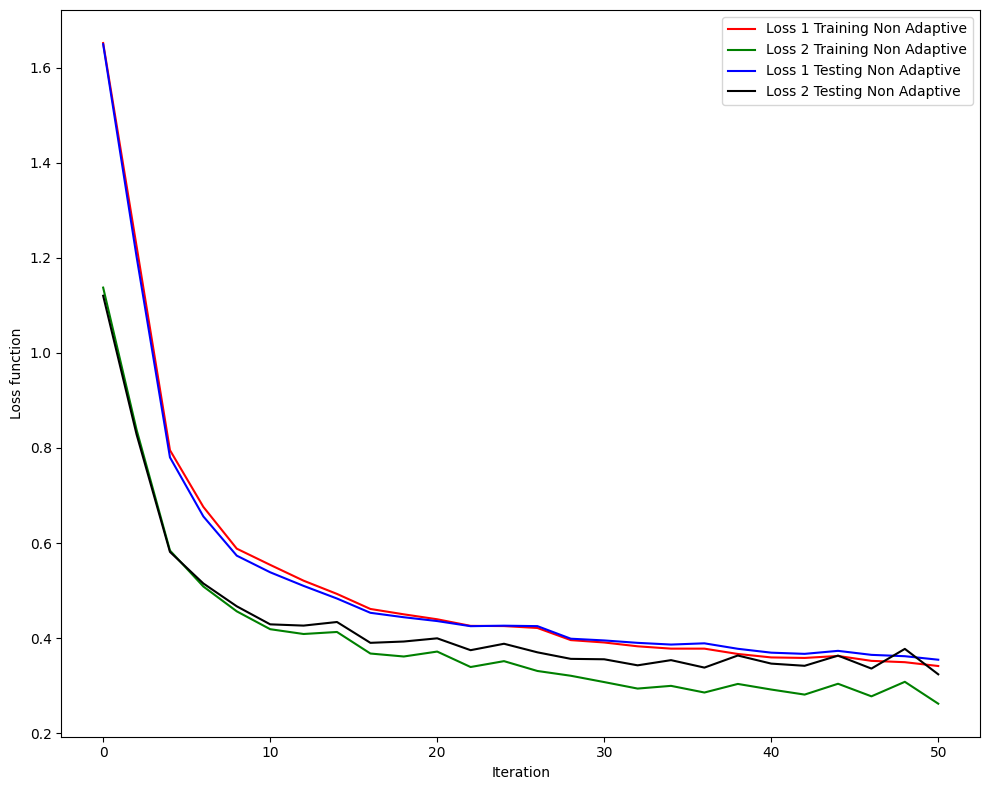

In [ ]:
loss_1_train_non = [task_train_losses_pref_non[1][0][0]]
loss_2_train_non = [task_train_losses_pref_non[1][0][1]]
loss_1_test_non = [task_test_losses_pref_non[1][0][0]]
loss_2_test_non = [task_test_losses_pref_non[1][0][1]]
for i, j in zip(task_train_losses_pref_non[1][1::2], task_test_losses_pref_non[1][1::2]):
  loss_1_train_non.append(i[0])
  loss_2_train_non.append(i[1])
  loss_1_test_non.append(j[0])
  loss_2_test_non.append(j[1])
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.plot(x, loss_1_train_non, color = 'r', label = 'Loss 1 Training Non Adaptive')
plt.plot(x, loss_2_train_non, color = 'g', label = 'Loss 2 Training Non Adaptive')
plt.plot(x, loss_1_test_non, color = 'blue', label = 'Loss 1 Testing Non Adaptive')
plt.plot(x, loss_2_test_non, color = 'black', label = 'Loss 2 Testing Non Adaptive')
# plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'Loss function')
plt.legend()
plt.tight_layout()
plt.show()

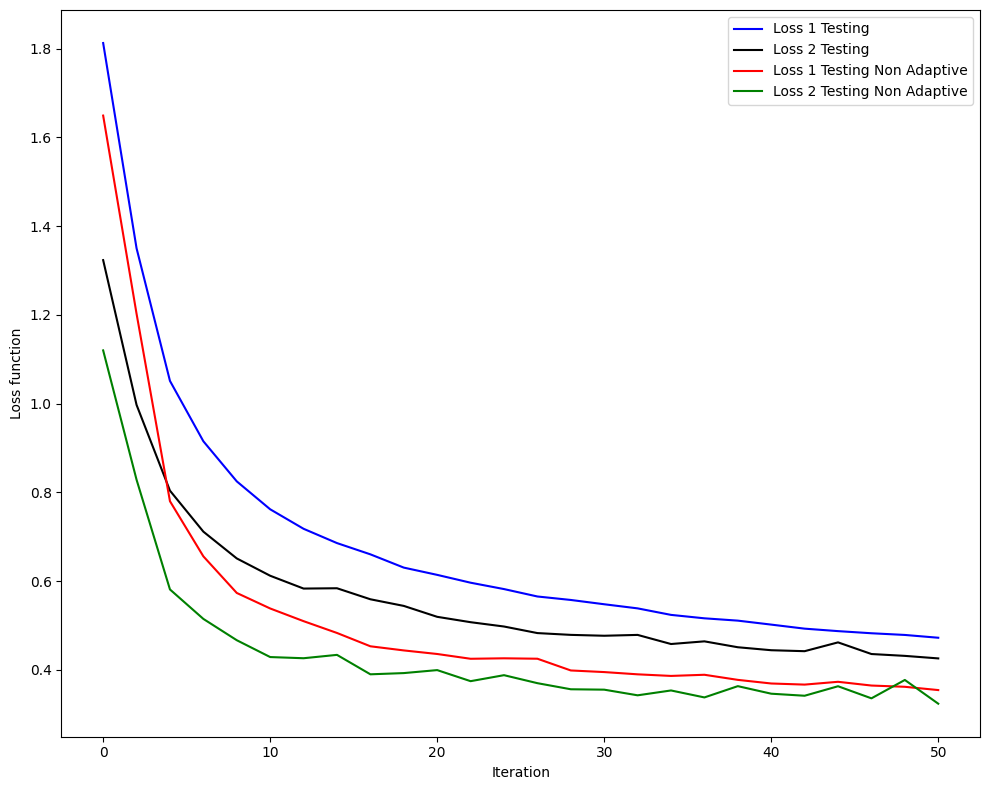

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.plot(x, loss_1_test, color = 'blue', label = 'Loss 1 Testing')
plt.plot(x, loss_2_test, color = 'black', label = 'Loss 2 Testing')

plt.plot(x, loss_1_test_non, color = 'r', label = 'Loss 1 Testing Non Adaptive')
plt.plot(x, loss_2_test_non, color = 'g', label = 'Loss 2 Testing Non Adaptive')
# plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'Loss function')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
acc_1_test[-1]

0.84715

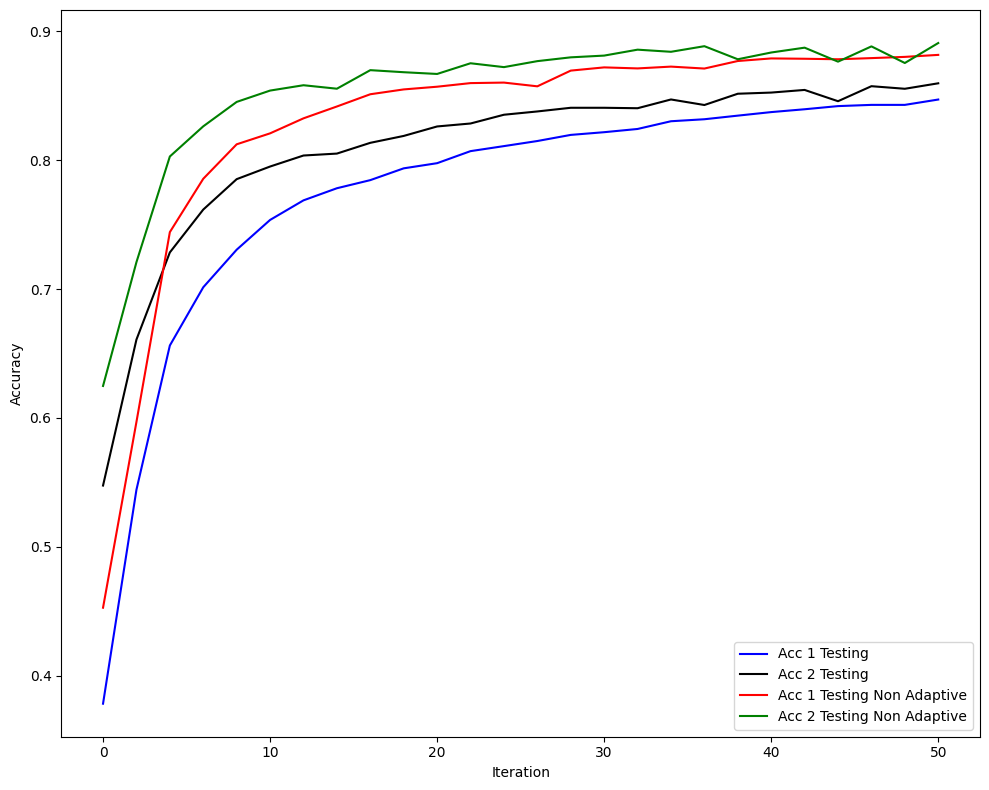

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.plot(x, acc_1_test, color = 'blue', label = 'Acc 1 Testing')
plt.plot(x, acc_2_test, color = 'black', label = 'Acc 2 Testing')

plt.plot(x, acc_1_test_non, color = 'r', label = 'Acc 1 Testing Non Adaptive')
plt.plot(x, acc_2_test_non, color = 'g', label = 'Acc 2 Testing Non Adaptive')
# plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Learning_Rate

In [ ]:
Learning_rate = [learning_rate_pref[0][0]]+ [learning_rate_pref[0][1]]*2+ [learning_rate_pref[0][2]]*2+ [learning_rate_pref[0][3]]*4+  [learning_rate_pref[0][4]]*4 + [learning_rate_pref[0][5]]*84
Learning_rate

[0.001,
 0.0009000000000000001,
 0.0009000000000000001,
 0.0008100000000000001,
 0.0008100000000000001,
 0.000729,
 0.000729,
 0.000729,
 0.000729,
 0.0006561000000000001,
 0.0006561000000000001,
 0.0006561000000000001,
 0.0006561000000000001,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0.00059049,
 0

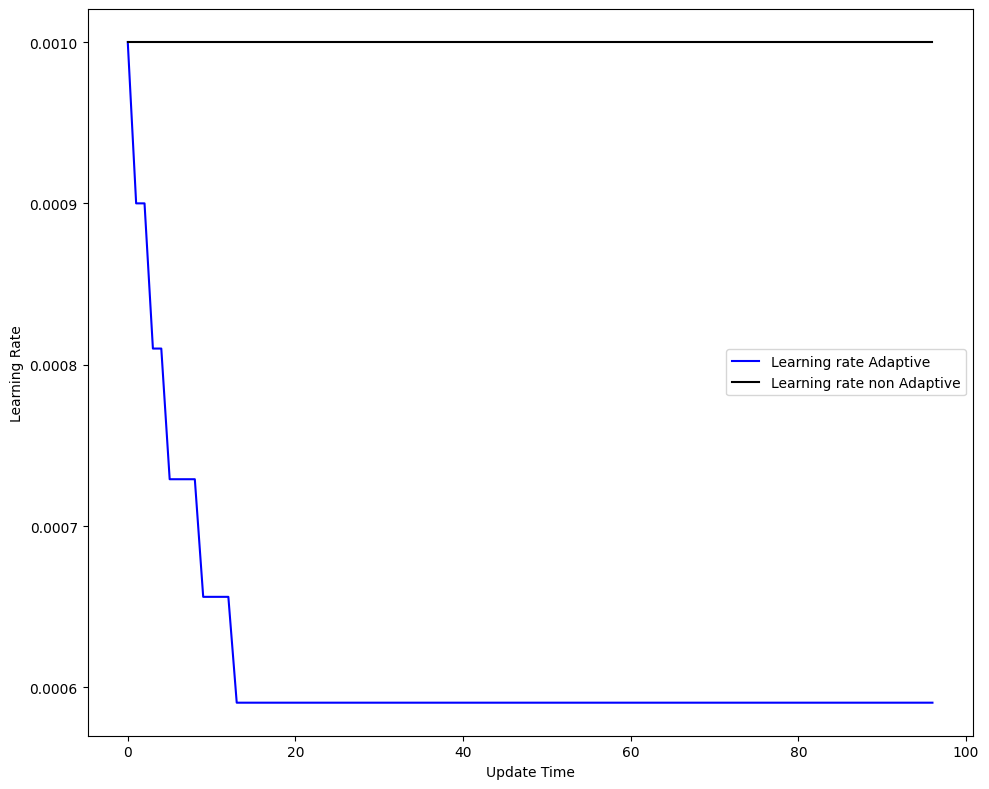

In [ ]:
learning_rate_non = learning_rate_pref_non[0]*len(Learning_rate)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.plot(Learning_rate , color = 'blue', label = 'Learning rate Adaptive')
plt.plot(learning_rate_non, color = 'black', label = 'Learning rate non Adaptive')

# plt.yscale('log')
plt.xlabel('Update Time')
plt.ylabel(r'Learning Rate')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#run(dataset = 'fashion', base_model = 'lenet', niter = 100, npref = 5)
#run(dataset = 'fashion_and_mnist', base_model = 'lenet', niter = 100, npref = 5)

#run(dataset = 'mnist', base_model = 'resnet18', niter = 20, npref = 5)
#run(dataset = 'fashion', base_model = 'resnet18', niter = 20, npref = 5)
#run(dataset = 'fashion_and_mnist', base_model = 'resnet18', niter = 20, npref = 5)